In [1]:
import datetime
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import time

from backtesting.test import SMA
from backtesting import Strategy, Backtest
from backtesting.lib import resample_apply,crossover

from skopt.plots import plot_objective

C:\Users\kmtk49\Anaconda3\envs\TF2-GPU\lib\site-packages\backtesting\_plotting.py:45: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [2]:
ticker = yf.Ticker("8015.T")
hist = ticker.history(period="6mo")
data = hist.iloc[:,:5]

# 計画行列
https://ja.wikipedia.org/wiki/%E8%A8%88%E7%94%BB%E8%A1%8C%E5%88%97
# 特徴量の作成

In [3]:
def BBANDS(data, n_lookback, n_std):
    """Bollinger bands indicator"""
    hlc3 = (data.High + data.Low + data.Close) / 3
    mean, std = hlc3.rolling(n_lookback).mean(), hlc3.rolling(n_lookback).std()
    upper = mean + n_std*std
    lower = mean - n_std*std
    return upper, lower


close = data.Close.values
sma10 = SMA(data.Close, 3)
sma20 = SMA(data.Close, 7)
sma50 = SMA(data.Close, 14)
sma100 = SMA(data.Close, 28)
upper, lower = BBANDS(data, 10, 2)

# Design matrix / independent features:

# Price-derived features
data['X_SMA10'] = (close - sma10) / close
data['X_SMA20'] = (close - sma20) / close
data['X_SMA50'] = (close - sma50) / close
data['X_SMA100'] = (close - sma100) / close

data['X_DELTA_SMA10'] = (sma10 - sma20) / close
data['X_DELTA_SMA20'] = (sma20 - sma50) / close
data['X_DELTA_SMA50'] = (sma50 - sma100) / close

# Indicator features
data['X_MOM'] = data.Close.pct_change(periods=2)
data['X_BB_upper'] = (upper - close) / close
data['X_BB_lower'] = (lower - close) / close
data['X_BB_width'] = (upper - lower) / close
data['X_Sentiment'] = ~data.index.to_series().between('2020-11-01', '2020-11-14')

# Some datetime features for good measure
data['X_day'] = data.index.dayofweek
data['X_hour'] = data.index.hour

data = data.dropna().astype(float)

In [4]:
data

,Open,High,Low,Close,Volume,X_SMA10,X_SMA20,X_SMA50,X_SMA100,X_DELTA_SMA10,X_DELTA_SMA20,X_DELTA_SMA50,X_MOM,X_BB_upper,X_BB_lower,X_BB_width,X_Sentiment,X_day,X_hour
Date,,,,,,,,,,,,,,,,,,,
2020-07-03,2722.991973,2726.926933,2637.406604,2670.853760,323700.0,-0.001105,-0.000263,-0.023231,-0.036411,0.000842,-0.022968,-0.013181,0.001845,0.044927,-0.021036,0.065963,1.0,4.0,0.0
2020-07-06,2681.674773,2734.796724,2664.951196,2723.975586,438900.0,0.011316,0.015220,0.000825,-0.017373,0.003904,-0.014394,-0.018199,0.014657,0.020118,-0.039090,0.059208,1.0,0.0,0.0
2020-07-07,2716.105801,2730.861899,2672.821247,2690.528564,371400.0,-0.001706,0.004074,-0.008122,-0.029956,0.005780,-0.012196,-0.021833,0.007366,0.021918,-0.022089,0.044007,1.0,1.0,0.0
2020-07-08,2665.934955,2705.284549,2646.260159,2652.162598,635000.0,-0.013848,-0.011181,-0.018705,-0.044404,0.002667,-0.007524,-0.025699,-0.026363,0.027005,-0.004552,0.031556,1.0,2.0,0.0
2020-07-09,2672.821230,2683.642369,2639.374075,2646.260254,603900.0,-0.006320,-0.011365,-0.017631,-0.045964,-0.005045,-0.006267,-0.028332,-0.016453,0.029182,-0.002095,0.031277,1.0,3.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-20,3415.000000,3460.000000,3390.000000,3415.000000,585900.0,-0.010249,-0.004811,0.030328,0.083821,0.005438,0.035139,0.053493,-0.020086,0.048281,-0.053259,0.101540,1.0,4.0,0.0
2020-11-24,3500.000000,3600.000000,3500.000000,3565.000000,943100.0,0.024778,0.028852,0.060208,0.116760,0.004074,0.031356,0.056552,0.033333,0.006107,-0.076982,0.083089,1.0,1.0,0.0
2020-11-25,3635.000000,3720.000000,3620.000000,3655.000000,1348200.0,0.030096,0.040453,0.071331,0.131542,0.010358,0.030877,0.060211,0.070278,0.003150,-0.106205,0.109355,1.0,2.0,0.0


# 作成した特徴量（指標）から学習用のx、yを取り出す

In [5]:
import numpy as np


def get_X(data):
    """Return model design matrix X"""
    return data.filter(like='X').values


def get_y(data):
    """Return dependent variable y"""
    y = data.Close.pct_change(5).shift(-5)  # Returns after 5 days
    y[y.between(-.04, .04)] = 0             # Devalue returns smaller than 4%
    y[y > 0] = 1
    y[y < 0] = -1
    return y


def get_clean_Xy(df):
    """Return (X, y) cleaned of NaN values"""
    X = get_X(df)
    y = get_y(df).values
    isnan = np.isnan(y)
    X = X[~isnan]
    y = y[~isnan]
    return X, y

# K近傍法で予測してみる

Classification accuracy:  0.6170212765957447


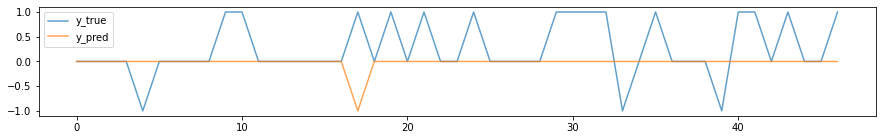

In [6]:
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

X, y = get_clean_Xy(data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5, random_state=0)

clf = KNeighborsClassifier(7)  # Model the output based on 7 "nearest" examples
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

_ = pd.DataFrame({'y_true': y_test, 'y_pred': y_pred}).plot(figsize=(15, 2), alpha=.7)
print('Classification accuracy: ', np.mean(y_test == y_pred))

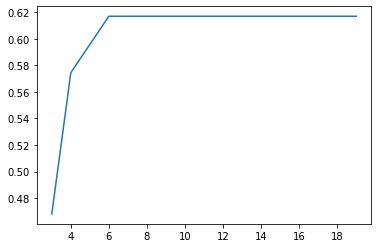

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

X, y = get_clean_Xy(data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5, random_state=0)

list_k = []
list_score = []

for i in range(3,20):
    clf = KNeighborsClassifier(n_neighbors=i)  # Model the output based on 7 "nearest" examples
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    #_ = pd.DataFrame({'y_true': y_test, 'y_pred': y_pred}).plot(figsize=(15, 2), alpha=.7)
    #print('Classification accuracy: ', np.mean(y_test == y_pred))
    list_k.append(i)
    list_score.append(np.mean(y_test == y_pred))

plt.plot(list_k, list_score)

## n=10以上はOverfitting気味か

In [8]:

from backtesting import Backtest, Strategy

N_TRAIN = 30


class MLTrainOnceStrategy(Strategy):
    price_delta = .04  # 4%

    def init(self):        
        # Init our model, a kNN classifier
        self.clf = KNeighborsClassifier(7)

        # Train the classifier in advance on the first N_TRAIN examples
        df = self.data.df.iloc[:N_TRAIN]
        X, y = get_clean_Xy(df)
        self.clf.fit(X, y)

        # Plot y for inspection
        self.I(get_y, self.data.df, name='y_true')

        # Prepare empty, all-NaN forecast indicator
        self.forecasts = self.I(lambda: np.repeat(np.nan, len(self.data)), name='forecast')

    def next(self):
        # Skip the training, in-sample data
        if len(self.data) < N_TRAIN:
            return

        # Proceed only with out-of-sample data. Prepare some variables
        high, low, close = self.data.High, self.data.Low, self.data.Close
        current_time = self.data.index[-1]

        # Forecast the next movement
        X = get_X(self.data.df.iloc[-1:])
        forecast = self.clf.predict(X)[0]

        # Update the plotted "forecast" indicator
        self.forecasts[-1] = forecast

        # If our forecast is upwards and we don't already hold a long position
        # place a long order for 20% of available account equity. Vice versa for short.
        # Also set target take-profit and stop-loss prices to be one price_delta
        # away from the current closing price.
        upper, lower = close[-1] * (1 + np.r_[1, -1]*self.price_delta)

        if forecast == 1 and not self.position.is_long:
            self.buy(size=.2, tp=upper, sl=lower)
        elif forecast == -1 and not self.position.is_short:
            self.sell(size=.2, tp=lower, sl=upper)

        # Additionally, set aggressive stop-loss on trades that have been open 
        # for more than two days
        for trade in self.trades:
            if current_time - trade.entry_time > pd.Timedelta('2 days'):
                if trade.is_long:
                    trade.sl = max(trade.sl, low)
                else:
                    trade.sl = min(trade.sl, high)


bt = Backtest(data, MLTrainOnceStrategy, commission=0.00125)
bt.run()

Start                     2020-07-03 00:00:00
End                       2020-11-27 00:00:00
Duration                    147 days 00:00:00
Exposure Time [%]                           0
Equity Final [$]                        10000
Equity Peak [$]                         10000
Return [%]                                  0
Buy & Hold Return [%]                 37.5965
Return (Ann.) [%]                           0
Volatility (Ann.) [%]                       0
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              NaN
Max. Drawdown [%]                          -0
Avg. Drawdown [%]                         NaN
Max. Drawdown Duration                    NaN
Avg. Drawdown Duration                    NaN
# Trades                                    0
Win Rate [%]                              NaN
Best Trade [%]                            NaN
Worst Trade [%]                           NaN
Avg. Trade [%]                    

In [9]:
bt.plot()

# ウォークフォワード分析
https://deasign.works/?p=66

In [10]:
class MLWalkForwardStrategy(MLTrainOnceStrategy):
    def next(self):
        # Skip the cold start period with too few values available
        if len(self.data) < N_TRAIN:
            return

        # Re-train the model only every 20 iterations.
        # Since 20 << N_TRAIN, we don't lose much in terms of
        # "recent training examples", but the speed-up is significant!
        if len(self.data) % 20:
            return super().next()

        # Retrain on last N_TRAIN values
        df = self.data.df[-N_TRAIN:]
        X, y = get_clean_Xy(df)
        self.clf.fit(X, y)

        # Now that the model is fitted, 
        # proceed the same as in MLTrainOnceStrategy
        super().next()


bt = Backtest(data, MLWalkForwardStrategy, commission=.000125)
bt.run()

Start                     2020-07-03 00:00:00
End                       2020-11-27 00:00:00
Duration                    147 days 00:00:00
Exposure Time [%]                           0
Equity Final [$]                        10000
Equity Peak [$]                         10000
Return [%]                                  0
Buy & Hold Return [%]                 37.5965
Return (Ann.) [%]                           0
Volatility (Ann.) [%]                       0
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              NaN
Max. Drawdown [%]                          -0
Avg. Drawdown [%]                         NaN
Max. Drawdown Duration                    NaN
Avg. Drawdown Duration                    NaN
# Trades                                    0
Win Rate [%]                              NaN
Best Trade [%]                            NaN
Worst Trade [%]                           NaN
Avg. Trade [%]                    

In [11]:
bt.plot()